In [18]:
import datetime
import pandas as pd

In [19]:
with open('temp.txt') as f:
    lines = f.readlines()

In [36]:
times = []
lats = []
lons = []
temps = []

for line in lines[:]:
    
    msgType = line.split(' ')[2]
    
    obsTime = datetime.datetime.strptime(line.split(': ')[0], "%Y-%m-%d %H:%M:%S.%f") 
    
    if msgType == 'GPS_RAW_INT' or msgType == 'GLOBAL_POSITION_INT':    
        
        lat = line.split('lat : ')[1].split(',')[0]
        lon = line.split('lon : ')[1].split(',')[0]
        
        lat = float( lat[0:2] + '.' + lat[2:] )
        lon = float( lon[0:3] + '.' + lon[3:] )
        
        times.append(obsTime)
        lats.append(lat)
        lons.append(lon)
        temps.append(None)
        
    elif msgType == 'NAMED_VALUE_FLOAT':    
        
        temp = float( line.split('H2O_TEMP, value : ')[1].split('}')[0] )
        
        times.append(obsTime)
        lats.append(None)
        lons.append(None)
        temps.append(temp)
        
    else:
        pass
        
df = pd.DataFrame.from_dict({
    'datetime':times,
    'lat':lats,
    'lon':lons,
    'temp':temps
})

df.to_csv('goosePosits.csv')
    

In [37]:
df

,datetime,lat,lon,temp
0,2023-05-18 15:41:31.380,NaN,NaN,25.963083
1,2023-05-18 15:41:32.430,NaN,NaN,25.961281
2,2023-05-18 15:41:33.420,NaN,NaN,25.982838
3,2023-05-18 15:41:34.450,NaN,NaN,26.012802
4,2023-05-18 15:41:35.710,NaN,NaN,25.995785
...,...,...,...,...
73802,2023-05-18 17:35:12.950,NaN,NaN,12.870465
73803,2023-05-18 17:35:13.970,NaN,NaN,12.852102
73804,2023-05-18 17:35:14.960,NaN,NaN,12.835732
73805,2023-05-18 17:35:16.100,NaN,NaN,12.834563


In [45]:
df2 = df.copy()
df2['lat'] = df2['lat'].interpolate(method='linear')
df2['lon'] = df2['lon'].interpolate(method='linear')
df2 = df2.dropna()
df2

,datetime,lat,lon,temp
59,2023-05-18 15:42:28.060,0.000000,0.000000,25.791656
66,2023-05-18 15:42:29.100,0.000000,0.000000,25.756468
73,2023-05-18 15:42:30.080,0.000000,0.000000,25.737772
80,2023-05-18 15:42:31.110,0.000000,0.000000,25.697704
88,2023-05-18 15:42:32.110,0.000000,0.000000,25.660706
...,...,...,...,...
73802,2023-05-18 17:35:12.950,42.687152,-76.956661,12.870465
73803,2023-05-18 17:35:13.970,42.687152,-76.956661,12.852102
73804,2023-05-18 17:35:14.960,42.687152,-76.956661,12.835732
73805,2023-05-18 17:35:16.100,42.687152,-76.956661,12.834563


In [46]:
df2.to_csv('goosePosits.csv')

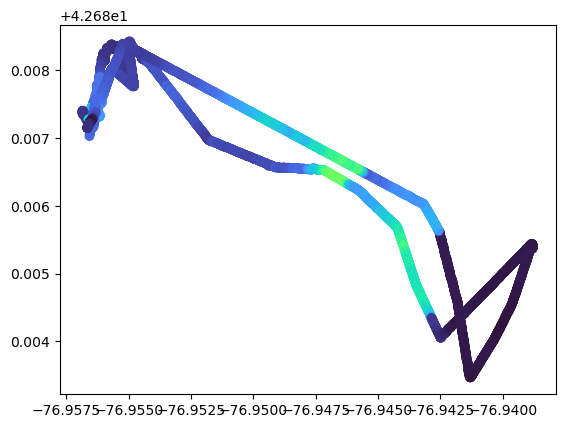

In [47]:
import matplotlib.pyplot as plt
df2 = df2[df2['lon']!=0.0]
df2 = df2[df2['lat']!=0.0]
plt.scatter(df2['lon'],df2['lat'],c=df2['temp'],cmap='turbo')
plt.show()

In [48]:
import rasterio # added using terminal command $   conda install -n gds_py rasterio
from rasterio.plot import show
from rasterio.mask import mask

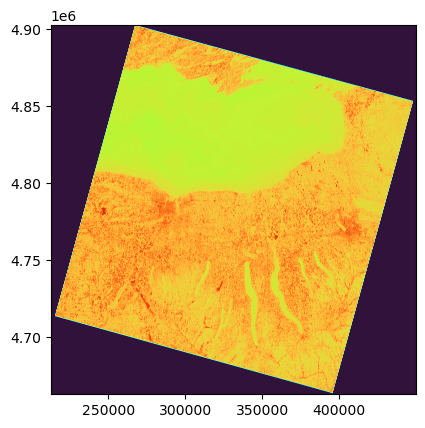

<AxesSubplot:>

In [50]:
fp = '2023_05_18/LC09_L1TP_016030_20230518_20230518_02_T1_B10.TIF'
img = rasterio.open(fp)
array = (img.read(1))
rasterio.plot.show(array,transform=img.transform,adjust=False,cmap='turbo')

#img.sample([(centroid.x,centroid.y)])

In [58]:
from pyproj import Transformer

def convertLatLonX(lat,lon,epsgNumber=2263):
    transformer = Transformer.from_crs( "epsg:4326", "epsg:{}".format(epsgNumber) ) 
    x, y = transformer.transform(lat, lon)
    return x

def convertLatLonY(lat,lon,epsgNumber=2263):
    transformer = Transformer.from_crs( "epsg:4326", "epsg:{}".format(epsgNumber) ) 
    x, y = transformer.transform(lat, lon)
    return y

def landsatSample(img,x,y):
    sample = 0
    for samp in img.sample([(x,y)]):
        sample = samp[0]
    return sample

epsg_code = int(img.crs.data['init'][5:])

print(epsg_code)

32618


In [59]:
df3 = pd.read_csv('goosePosits.csv')

df3['x'] = df3.apply(lambda x: convertLatLonX(x['lat'],x['lon'],epsg_code), axis=1 )
df3['y'] = df3.apply(lambda x: convertLatLonY(x['lat'],x['lon'],epsg_code), axis=1 )
df3['b10samp'] = df3.apply(lambda x: landsatSample(img,x['x'],x['y']), axis=1 )

df3.to_csv('gooseAndLandsat.csv')

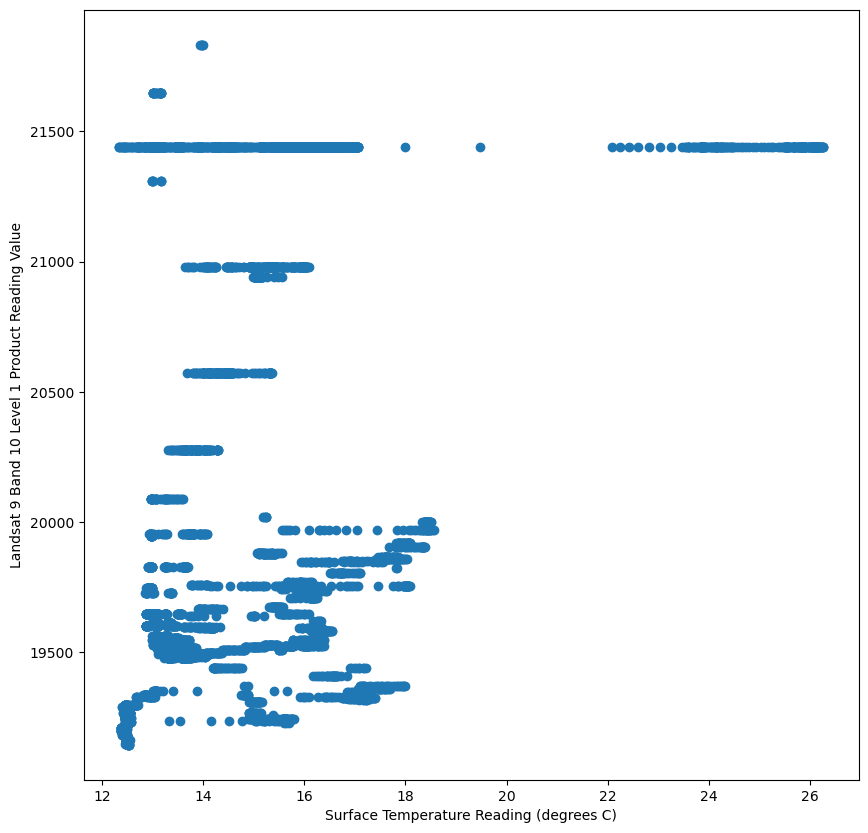

In [65]:
df4 = df3[df3['temp']>0]
df4 = df3[df3['b10samp']>0]
plt.figure(figsize=(10,10))
plt.scatter(df4['temp'],df4['b10samp'])
plt.xlabel('Surface Temperature Reading (degrees C)')
plt.ylabel('Landsat 9 Band 10 Level 1 Product Reading Value')
plt.show()